<a href="https://colab.research.google.com/github/chitra-psg/bike_sharing/blob/main/bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BoomBikes Demand Regression

BoomBikes  wanted to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands

In [461]:
# Import the required modules
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Configurations
import warnings
warnings.filterwarnings('ignore')

In [462]:
# Function to calcualte VIF 
def GetVIF(X):
  vif = pd.DataFrame()
  X = X.drop(['const'], axis=1)
  vif['Features'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif

# Function to create linear regession model and fit it.
def GetLinearRegression(X_train, y_train):
    # Add a constant
    X_train_lm = sm.add_constant(X_train)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr


In [463]:
# A function has been created to map the actual numbers to categorical levels.

# Assigning string values to different months instead of numeric values which may misindicate some order to it.
def MapMonths(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})

def MapSeasons(x):
    return x.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})

def MapWeather(x):
    return x.map({1: 'Clear', 2: 'Cloudy', 3: 'LightRain', 4: 'HeavyRain'})

def MapBoolean(x):
    return x.map({0: 'No', 1: 'Yes'})

# **Data Preparation**

In [464]:
# Load the source data from GitHub into dataframe for analysis
# Load all column data in and then determine data type : low_memory=False
df_bike = pd.read_csv("https://github.com/chitra-psg/bike_sharing/blob/main/day.csv?raw=True", low_memory=False)
df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.1108,18.1812,80.5833,10.7499,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.9026,17.6869,69.6087,16.6521,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.0509,9.4703,43.7273,16.6367,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.2000,10.6061,59.0435,10.7398,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.3052,11.4635,43.6957,12.5223,82,1518,1600


In [465]:
df_bike.info()
# Summary :
# Most of the columns are numeric type except date and date will have to be converted to Date type.
# There doesnt seem to be any nulls in any row/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [466]:
df_bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000
mean,365.5000,2.4986,0.5000,6.5260,0.0288,2.9973,0.6836,1.3945,20.3193,23.7263,62.7652,12.7636,849.2493,3658.7575,4508.0068
std,210.8771,1.1102,0.5003,3.4502,0.1673,2.0062,0.4654,0.5448,7.5067,8.1503,14.2376,5.1958,686.4799,1559.7587,1936.0116
min,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,2.4243,3.9535,0.0000,1.5002,2.0000,20.0000,22.0000
25%,183.2500,2.0000,0.0000,4.0000,0.0000,1.0000,0.0000,1.0000,13.8119,16.8897,52.0000,9.0417,316.2500,2502.2500,3169.7500
50%,365.5000,3.0000,0.5000,7.0000,0.0000,3.0000,1.0000,1.0000,20.4658,24.3682,62.6250,12.1253,717.0000,3664.5000,4548.5000
75%,547.7500,3.0000,1.0000,10.0000,0.0000,5.0000,1.0000,2.0000,26.8806,30.4458,72.9896,15.6256,1096.5000,4783.2500,5966.0000
max,730.0000,4.0000,1.0000,12.0000,1.0000,6.0000,1.0000,3.0000,35.3283,42.0448,97.2500,34.0000,3410.0000,6946.0000,8714.0000


In [467]:

pd.options.display.float_format = '{:.4f}'.format
df_bike.corr()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.0000,0.4136,0.8660,0.4983,0.0163,-0.0000,-0.0046,-0.0219,0.1507,0.1528,0.0161,-0.1127,0.2756,0.6605,0.6299
season,0.4136,1.0000,-0.0000,0.8310,-0.0109,-0.0031,0.0138,0.0213,0.3334,0.3420,0.2082,-0.2296,0.2087,0.4103,0.4046
yr,0.8660,-0.0000,1.0000,-0.0000,0.0082,-0.0055,-0.0029,-0.0503,0.0488,0.0472,-0.1125,-0.0116,0.2505,0.5969,0.5697
mnth,0.4983,0.8310,-0.0000,1.0000,0.0189,0.0095,-0.0047,0.0456,0.2191,0.2264,0.2249,-0.2080,0.1212,0.2920,0.2782
holiday,0.0163,-0.0109,0.0082,0.0189,1.0000,-0.1020,-0.2529,-0.0344,-0.0288,-0.0327,-0.0157,0.0063,0.0541,-0.1091,-0.0688
weekday,-0.0000,-0.0031,-0.0055,0.0095,-0.1020,1.0000,0.0358,0.0311,-0.0002,-0.0075,-0.0523,0.0143,0.0600,0.0574,0.0675
workingday,-0.0046,0.0138,-0.0029,-0.0047,-0.2529,0.0358,1.0000,0.0602,0.0535,0.0529,0.0232,-0.0187,-0.5176,0.3054,0.0625
weathersit,-0.0219,0.0213,-0.0503,0.0456,-0.0344,0.0311,0.0602,1.0000,-0.1195,-0.1206,0.5903,0.0398,-0.2460,-0.2590,-0.2959
temp,0.1507,0.3334,0.0488,0.2191,-0.0288,-0.0002,0.0535,-0.1195,1.0000,0.9917,0.1286,-0.1582,0.5427,0.5394,0.6270
atemp,0.1528,0.3420,0.0472,0.2264,-0.0327,-0.0075,0.0529,-0.1206,0.9917,1.0000,0.1415,-0.1839,0.5434,0.5437,0.6307


# Columns that can be dropped -
*   instant   : row number
*   dteday    : a date field which is also available in yr and mnt column
*   casual    : type of bike sharing, also available in cnt field
*   registered: type of bike sharing, also available in cnt field
*   atemp     : feeling temperature which is highly correlated with temp field

In [468]:
ls_columns_to_be_dropped = ['instant', 'dteday', 'casual', 'registered','atemp']

df_bike.drop(ls_columns_to_be_dropped, axis=1, inplace=True)
df_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.1108,80.5833,10.7499,985
1,1,0,1,0,0,0,2,14.9026,69.6087,16.6521,801
2,1,0,1,0,1,1,1,8.0509,43.7273,16.6367,1349
3,1,0,1,0,2,1,1,8.2000,59.0435,10.7398,1562
4,1,0,1,0,3,1,1,9.3052,43.6957,12.5223,1600


In [469]:
# Applying the function to the categorical columns
df_bike[['mnth']] = df_bike[['mnth']].apply(MapMonths)
df_bike[['season']] = df_bike[['season']].apply(MapSeasons)
df_bike[['weathersit']] = df_bike[['weathersit']].apply(MapWeather)
df_bike[['holiday']] = df_bike[['holiday']].apply(MapBoolean)
#df_bike[['weekday']] = df_bike[['weekday']].apply(MapBoolean)
df_bike[['workingday']] = df_bike[['workingday']].apply(MapBoolean)

In [470]:
# Analyse the values in the variables
print(df_bike['season'].value_counts(), '\n')
print(df_bike['holiday'].value_counts(), '\n')
print(df_bike['weekday'].value_counts(), '\n')
print(df_bike['workingday'].value_counts(), '\n') 
print(df_bike['weathersit'].value_counts(), '\n')
print(df_bike['temp'].value_counts(), '\n')
print(df_bike['hum'].value_counts(), '\n')
print(df_bike['windspeed'].value_counts(), '\n')
print(df_bike['yr'].value_counts(), '\n')
print(df_bike['mnth'].value_counts().sort_index(ascending=True), '\n')

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64 

No     709
Yes     21
Name: holiday, dtype: int64 

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64 

Yes    499
No     231
Name: workingday, dtype: int64 

Clear        463
Cloudy       246
LightRain     21
Name: weathersit, dtype: int64 

26.0350    5
10.8992    5
27.8800    4
28.5633    4
23.1308    4
          ..
27.4358    1
26.3767    1
28.9894    1
28.7000    1
8.8492     1
Name: temp, Length: 498, dtype: int64 

61.3333    4
63.0833    3
55.2083    3
60.5000    3
56.8333    3
          ..
54.8333    1
56.1765    1
85.0000    1
76.1250    1
57.7500    1
Name: hum, Length: 594, dtype: int64 

9.0419     3
11.1667    3
11.2501    3
15.3335    3
7.9591     3
          ..
12.4168    1
13.8333    1
14.2506    1
23.0442    1
10.3747    1
Name: windspeed, Length: 649, dtype: int64 

0    365
1    365
Name: yr, dtype: int64 

Apr     60
Aug     62
Dec     62
Fe

# **Data Analysis**

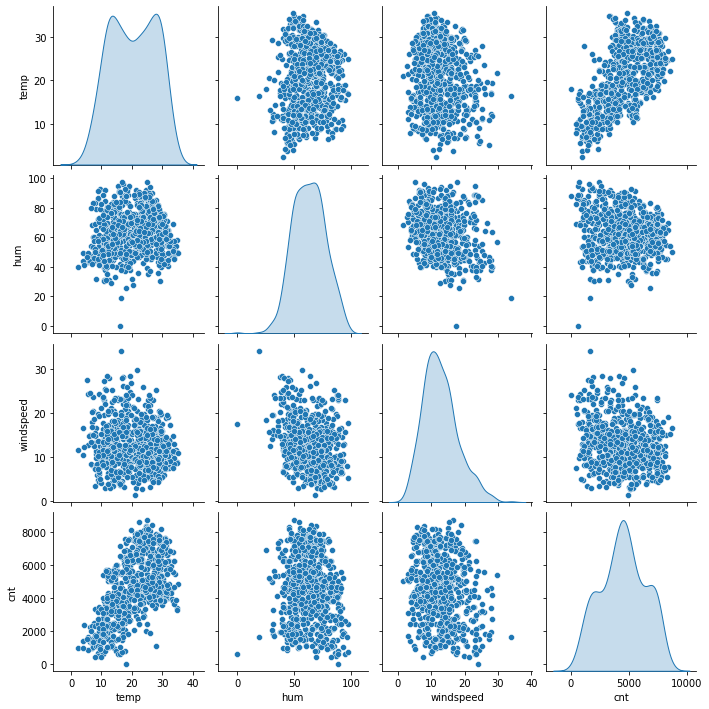

In [471]:
#check relationship between continuous variables 
df_bike_select=df_bike[['temp', 'hum', 'windspeed','cnt']]

sns.pairplot(df_bike_select, diag_kind='kde')
plt.show()

In [472]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 62.9+ KB


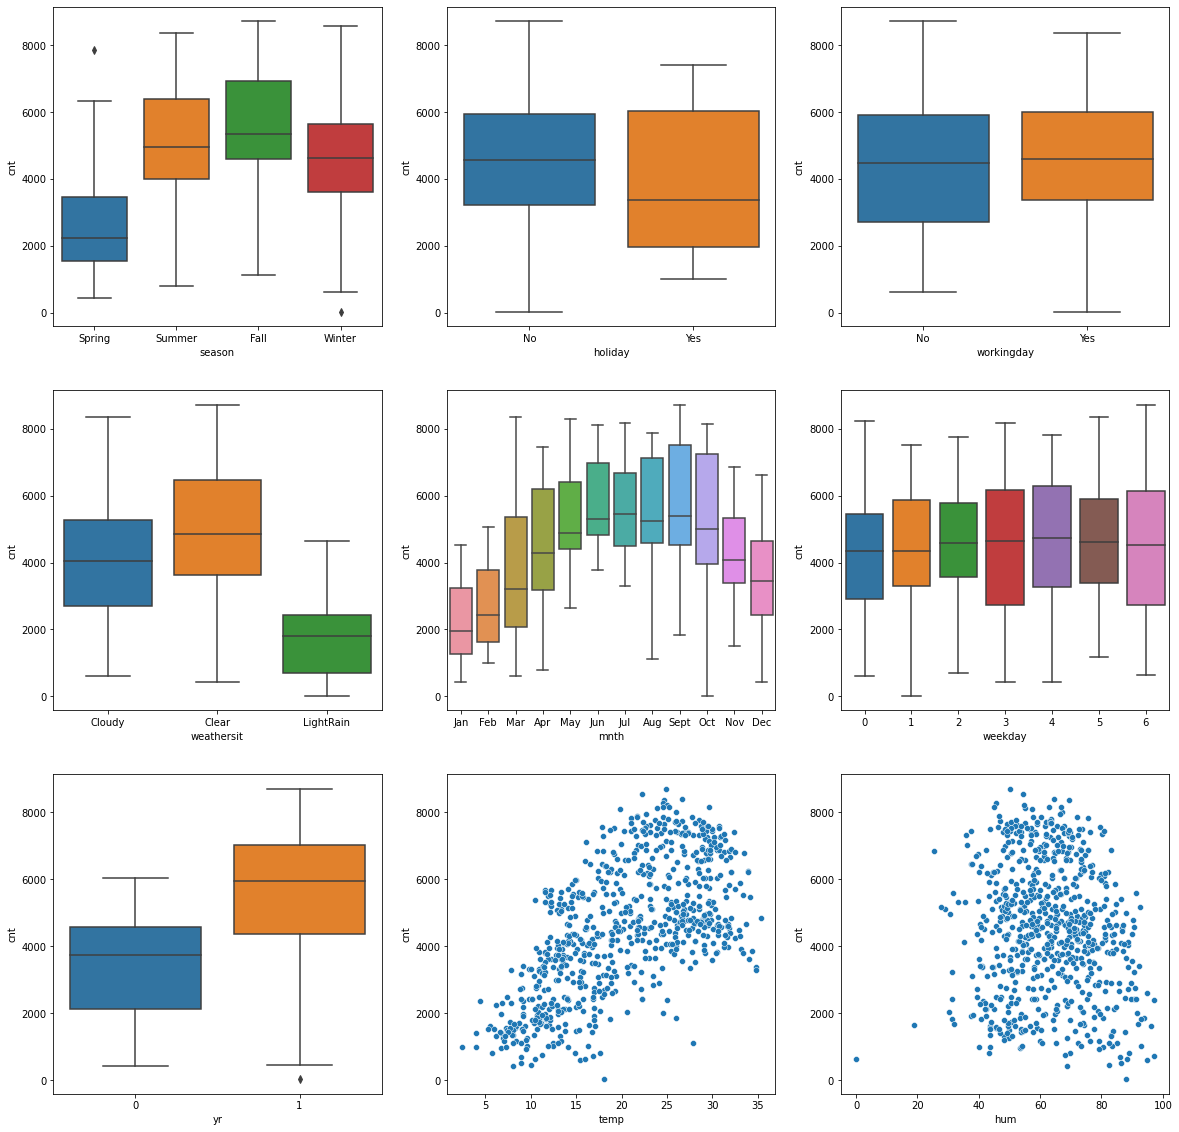

In [473]:
plt.figure(figsize=(20, 20))  
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(3,3,7)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bike)
plt.subplot(3,3,8)
sns.scatterplot(x = 'temp', y = 'cnt', data = df_bike)
plt.subplot(3,3,9)
sns.scatterplot(x = 'hum', y = 'cnt', data = df_bike)
plt.show()


#**Data Insights**

> temp     -> Bike demand is increasing as the temp increases.

> Yr         -> Bike Sharing is higher in 2019 when compared to 2018

> Season     -> Summer and Fall have high bike demand

> Weathersit -> Bike demand decreases when there is Light Rain and higher when it is clear

> Holiday   -> Lower demand on holidays

> weekday   -> This variable doesnt seem to be impacting the bike demand

> workingday-> This variable doesnt seem to be impacting the bike demand

> Season -> there is relationship between Season and months. Fall months do have higher bike demand
1.   Spring : Dec, Jan, Feb, Mar
2.   Summer : Mar, Apr, May, Jun
3.   Fall   : Jun, Jul Aug, Sep
4.   Winter : Sep, Oct, Nov, Dec

# ***Model building***

# Create dummy variables

In [474]:
#Convert categorial variables into category data type to create dummy columns
df_bike['season']     = df_bike['season'].astype('category')
df_bike['holiday'] = df_bike['holiday'].astype('category')
df_bike['mnth'] = df_bike['mnth'].astype('category')
df_bike['weathersit'] = df_bike['weathersit'].astype('category')
df_bike['weekday']    = df_bike['weekday'].astype('category')
df_bike['workingday']    = df_bike['workingday'].astype('category')

In [475]:
#Create dummy columns for categorical variables and drop the first column
df_new_bike = pd.get_dummies(df_bike, drop_first=True)
df_new_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yr                    730 non-null    int64  
 1   temp                  730 non-null    float64
 2   hum                   730 non-null    float64
 3   windspeed             730 non-null    float64
 4   cnt                   730 non-null    int64  
 5   season_Spring         730 non-null    uint8  
 6   season_Summer         730 non-null    uint8  
 7   season_Winter         730 non-null    uint8  
 8   mnth_Aug              730 non-null    uint8  
 9   mnth_Dec              730 non-null    uint8  
 10  mnth_Feb              730 non-null    uint8  
 11  mnth_Jan              730 non-null    uint8  
 12  mnth_Jul              730 non-null    uint8  
 13  mnth_Jun              730 non-null    uint8  
 14  mnth_Mar              730 non-null    uint8  
 15  mnth_May              7

# Split the data into training and testing Sets

In [476]:
# We should specify 'random_state' so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df_new_bike, train_size = 0.70, test_size = 0.30, random_state = 100)

#Rescaling features

In [477]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ls_num_vars = ['temp', 'hum', 'windspeed','cnt']
df_train[ls_num_vars] = scaler.fit_transform(df_train[ls_num_vars])

In [478]:
df_train.describe()

,yr,temp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,...,holiday_Yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_Yes,weathersit_Cloudy,weathersit_LightRain
count,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,...,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000
mean,0.5078,0.5373,0.6504,0.3208,0.5136,0.2431,0.2451,0.2490,0.0961,0.0843,...,0.0255,0.1510,0.1314,0.1588,0.1333,0.1275,0.1549,0.6765,0.3431,0.0294
std,0.5004,0.2258,0.1459,0.1698,0.2246,0.4294,0.4306,0.4329,0.2950,0.2781,...,0.1578,0.3584,0.3381,0.3659,0.3403,0.3338,0.3622,0.4683,0.4752,0.1691
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.3399,0.5386,0.1992,0.3564,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,0.5405,0.6537,0.2968,0.5186,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
75%,1.0000,0.7352,0.7548,0.4144,0.6847,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# Dividing into X and Y sets for the model building

In [479]:
y_train = df_train.pop('cnt')
X_train = df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yr                    510 non-null    int64  
 1   temp                  510 non-null    float64
 2   hum                   510 non-null    float64
 3   windspeed             510 non-null    float64
 4   season_Spring         510 non-null    uint8  
 5   season_Summer         510 non-null    uint8  
 6   season_Winter         510 non-null    uint8  
 7   mnth_Aug              510 non-null    uint8  
 8   mnth_Dec              510 non-null    uint8  
 9   mnth_Feb              510 non-null    uint8  
 10  mnth_Jan              510 non-null    uint8  
 11  mnth_Jul              510 non-null    uint8  
 12  mnth_Jun              510 non-null    uint8  
 13  mnth_Mar              510 non-null    uint8  
 14  mnth_May              510 non-null    uint8  
 15  mnth_Nov              

# Feature Engineering

## RFE

In [480]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select = 12)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('mnth_Aug', False, 9),
 ('mnth_Dec', False, 6),
 ('mnth_Feb', False, 7),
 ('mnth_Jan', False, 4),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 15),
 ('mnth_Mar', False, 17),
 ('mnth_May', False, 8),
 ('mnth_Nov', False, 5),
 ('mnth_Oct', False, 12),
 ('mnth_Sept', True, 1),
 ('holiday_Yes', True, 1),
 ('weekday_1', False, 10),
 ('weekday_2', False, 11),
 ('weekday_3', False, 14),
 ('weekday_4', False, 16),
 ('weekday_5', False, 13),
 ('weekday_6', False, 2),
 ('workingday_Yes', False, 3),
 ('weathersit_Cloudy', True, 1),
 ('weathersit_LightRain', True, 1)]

In [481]:
ls_selected_col = X_train.columns[rfe.support_]
ls_selected_col

Index(['yr', 'temp', 'hum', 'windspeed', 'season_Spring', 'season_Summer',
       'season_Winter', 'mnth_Jul', 'mnth_Sept', 'holiday_Yes',
       'weathersit_Cloudy', 'weathersit_LightRain'],
      dtype='object')

### Building model using statsmodel

In [482]:
# Adding a constant variable 
import statsmodels.api as sm  
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[ls_selected_col]
 
X_train_rfe = sm.add_constant(X_train_rfe)

In [483]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          1.69e-190
Time:                        17:51:35   Log-Likelihood:                 509.47
No. Observations:                 510   AIC:                            -992.9
Df Residuals:                     497   BIC:                            -937.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2841 

In [484]:
# Calculate VIF
GetVIF(X_train_rfe)

,Features,VIF
2,hum,28.0600
1,temp,16.0200
3,windspeed,4.6500
4,season_Spring,4.0100
6,season_Winter,3.3500
5,season_Summer,2.7800
10,weathersit_Cloudy,2.2800
0,yr,2.0800
7,mnth_Jul,1.5800
8,mnth_Sept,1.3800


### Action for next model

> If VIF is less than 5 then we can consider those but those above 10 has to be removed as resolve multicollenarity

> Looking at p value in the summary, we can see high value in season_Spring and mnth_July. We can look remove these one by one in the next iterations

> First, we will remove hum



In [485]:
X_train_rfe = X_train_rfe.drop(["hum"], axis = 1)
lm1 = GetLinearRegression(X_train_rfe, y_train)
lm1.params

const                   0.1996
yr                      0.2335
temp                    0.4915
windspeed              -0.1480
season_Spring          -0.0669
season_Summer           0.0453
season_Winter           0.0831
mnth_Jul               -0.0524
mnth_Sept               0.0767
holiday_Yes            -0.0980
weathersit_Cloudy      -0.0816
weathersit_LightRain   -0.2852
dtype: float64

In [486]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          2.40e-187
Time:                        17:51:35   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1996      0.030      6.758      0.000       0.142       0.258
yr                       0.2335      0.008     28.361      0.000       0.217       0.250
temp                     0.4915      0.033     14.798      0.000       0.426       0.557
windspeed               -0.1480      0.025     -5.893      0.000      -0.197      -0.099
season_Spring           -0.0669      0.021     -3.167      0.002      -0.108      -0.025
season_Summer            0.0453      0.015      2.971      0.003       0.015       0.075
season_Winter            0.0831      0.017      4.818      0.000       0.049       0.117
mnth_Jul                -0.0524      0.019     -2.811      0.005      -0.089      -0.016
mnth_Sept                0.0767      0.017      4.511      0.000       0.043       0.110
holiday_Yes             -0.0980      0.026     -3.761      0.000      -0.149      -0.047
weathersit_Cloudy       -0.0816      0.009     -9.301      0.000      -0.099      -0.064
weathersit_LightRain    -0.2852      0.025    -11.536      0.000      -0.334      -0.237
==============================================================================
Omnibus:                       59.298   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.189
Skew:                          -0.628   Prob(JB):                     4.41e-30
Kurtosis:                       5.187   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [487]:
GetVIF(X_train_rfe)

,Features,VIF
1,temp,5.0900
2,windspeed,4.6000
4,season_Summer,2.2100
3,season_Spring,2.0800
0,yr,2.0700
5,season_Winter,1.7900
6,mnth_Jul,1.5800
9,weathersit_Cloudy,1.5500
7,mnth_Sept,1.3400
10,weathersit_LightRain,1.0800


In [488]:
X_train_rfe = X_train_rfe.drop(["mnth_Jul"], axis = 1)
lm2 = GetLinearRegression(X_train_rfe, y_train)
lm2.params

const                   0.1910
yr                      0.2341
temp                    0.4782
windspeed              -0.1482
season_Spring          -0.0551
season_Summer           0.0610
season_Winter           0.0959
mnth_Sept               0.0909
holiday_Yes            -0.0969
weathersit_Cloudy      -0.0801
weathersit_LightRain   -0.2860
dtype: float64

In [489]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          7.36e-187
Time:                        17:51:35   Log-Likelihood:                 495.16
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     499   BIC:                            -921.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1910      0.030      6.456      0.000       0.133       0.249
yr                       0.2341      0.008     28.246      0.000       0.218       0.250
temp                     0.4782      0.033     14.446      0.000       0.413       0.543
windspeed               -0.1482      0.025     -5.860      0.000      -0.198      -0.098
season_Spring           -0.0551      0.021     -2.641      0.009      -0.096      -0.014
season_Summer            0.0610      0.014      4.271      0.000       0.033       0.089
season_Winter            0.0959      0.017      5.730      0.000       0.063       0.129
mnth_Sept                0.0909      0.016      5.565      0.000       0.059       0.123
holiday_Yes             -0.0969      0.026     -3.691      0.000      -0.148      -0.045
weathersit_Cloudy       -0.0801      0.009     -9.090      0.000      -0.097      -0.063
weathersit_LightRain    -0.2860      0.025    -11.492      0.000      -0.335      -0.237
==============================================================================
Omnibus:                       63.599   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.759
Skew:                          -0.674   Prob(JB):                     6.07e-32
Kurtosis:                       5.225   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [490]:
X_train_rfe = X_train_rfe.drop(["season_Spring"], axis = 1)
lm3 = GetLinearRegression(X_train_rfe, y_train)
lm3.params

const                   0.1264
yr                      0.2328
temp                    0.5480
windspeed              -0.1533
season_Summer           0.0868
season_Winter           0.1306
mnth_Sept               0.1011
holiday_Yes            -0.0992
weathersit_Cloudy      -0.0797
weathersit_LightRain   -0.2838
dtype: float64

In [491]:
#df_vif = X_train_rfe.drop(['const'], axis=1)
GetVIF(X_train_rfe)

,Features,VIF
1,temp,3.6800
2,windspeed,3.0500
0,yr,2.0000
3,season_Summer,1.5600
7,weathersit_Cloudy,1.4800
4,season_Winter,1.3800
5,mnth_Sept,1.2000
8,weathersit_LightRain,1.0800
6,holiday_Yes,1.0300


In [492]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     272.9
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          1.37e-186
Time:                        17:51:35   Log-Likelihood:                 491.62
No. Observations:                 510   AIC:                            -963.2
Df Residuals:                     500   BIC:                            -920.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1264      0.017      7.541      0.000       0.093       0.159
yr                       0.2328      0.008     27.973      0.000       0.216       0.249
temp                     0.5480      0.020     27.381      0.000       0.509       0.587
windspeed               -0.1533      0.025     -6.045      0.000      -0.203      -0.103
season_Summer            0.0868      0.010      8.307      0.000       0.066       0.107
season_Winter            0.1306      0.010     12.476      0.000       0.110       0.151
mnth_Sept                0.1011      0.016      6.327      0.000       0.070       0.132
holiday_Yes             -0.0992      0.026     -3.761      0.000      -0.151      -0.047
weathersit_Cloudy       -0.0797      0.009     -8.995      0.000      -0.097      -0.062
weathersit_LightRain    -0.2838      0.025    -11.344      0.000      -0.333      -0.235
==============================================================================
Omnibus:                       57.277   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.021
Skew:                          -0.648   Prob(JB):                     6.40e-26
Kurtosis:                       4.945   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Residual Analysis

In [493]:
y_train_cnt = lm3.predict(X_train_rfe)

Text(0.5, 0, 'Errors')

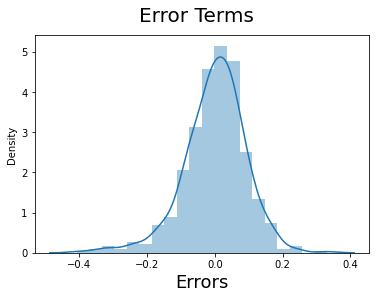

In [494]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

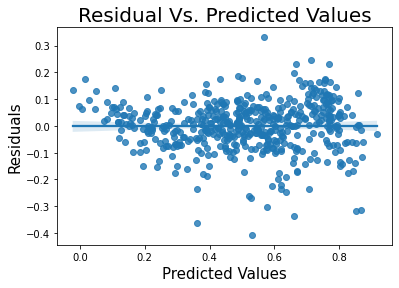

In [495]:
sns.regplot(x=y_train_cnt, y=(y_train - y_train_cnt))
plt.title('Residual Vs. Predicted Values', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

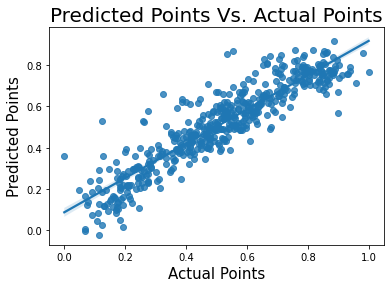

In [496]:
sns.regplot(x=y_train, y=y_train_cnt)
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

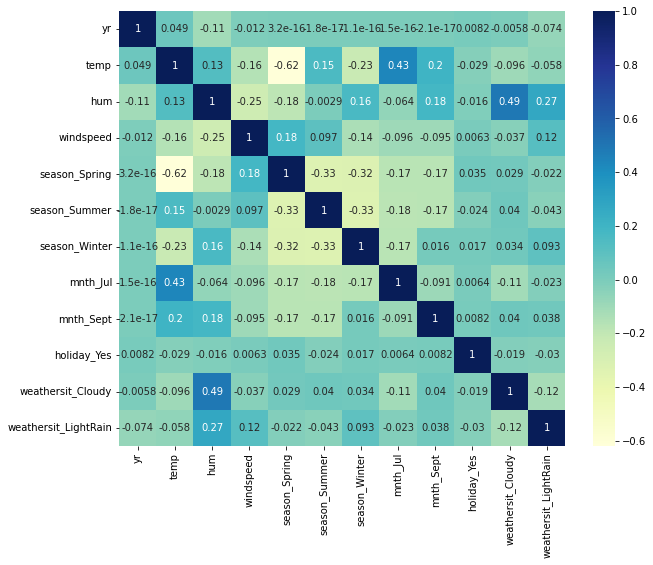

In [502]:
# Figure size
plt.figure(figsize=(10,8))

# Heatmap
sns.heatmap(df_new_bike[ls_selected_col].corr(), cmap="YlGnBu", annot=True)
plt.show()

# Making predictions

In [497]:
df_test[ls_num_vars] = scaler.transform(df_test[ls_num_vars])

In [498]:
df_test.describe()

,yr,temp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,...,holiday_Yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_Yes,weathersit_Cloudy,weathersit_LightRain
count,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,...,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000,219.0000
mean,0.4795,0.5589,0.6385,0.3133,0.5206,0.2557,0.2648,0.2329,0.0594,0.0868,...,0.0365,0.1279,0.1644,0.1005,0.1644,0.1781,0.1187,0.6986,0.3196,0.0274
std,0.5007,0.2337,0.1490,0.1599,0.2184,0.4373,0.4423,0.4236,0.2368,0.2821,...,0.1880,0.3347,0.3715,0.3013,0.3715,0.3835,0.3242,0.4599,0.4674,0.1636
min,0.0000,0.0466,0.2619,-0.0428,0.0482,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.3546,0.5273,0.1985,0.3775,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.5587,0.6277,0.2995,0.5243,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
75%,1.0000,0.7591,0.7439,0.4030,0.6727,1.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
max,1.0000,0.9844,1.0021,0.8075,0.9633,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [499]:
y_test = df_test.pop('cnt')
X_test = df_test

# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_train_new = X_train_rfe.drop(['const'], axis=1)
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_test_pred = lm3.predict(X_test_new)

Text(0, 0.5, 'y_pred')

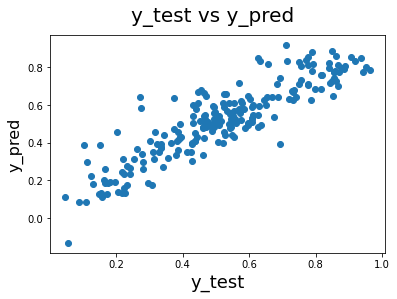

In [500]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [503]:
from sklearn.metrics import r2_score
r2= r2_score(y_test, y_test_pred)

X_test.shape
# n is number of rows in X
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("R2 =" ,r2, "\nAdjusted R2 =",adjusted_r2)

R2 = 0.7938290016640651 
Adjusted R2 = 0.7634459071724536


# Conclusion

## Top 3 variables are - 
*   Temp
*   Weather- Light Rain
*   Year